<a href="https://colab.research.google.com/github/roksanakanicka/Predicting_Student_Test_Scores/blob/main/Przewidywanie_wynik%C3%B3w_edukacyjnych.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Student Test Scores
##Kaggle Playground Competition

In [60]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

### Wczytanie danych

In [61]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# oryginalny dataset, z którego zostały wygenerowane syntetyczne dane train i test
original_set = pd.read_csv('Exam_Score_Prediction.csv')

# original_set ma "student_id" zamiast "id"
if 'student_id' in original_set.columns:
    original_set = original_set.rename(columns={'student_id': 'id'})

In [62]:
print(f"Train shape: {train.shape}, Test shape: {test.shape}, Original shape: {original_set.shape}")

Train shape: (630000, 13), Test shape: (270000, 12), Original shape: (20000, 13)


### Selekcja cech

In [63]:
# Usuwamy nieistotne kolumny (p > 0.05)
cols_to_drop = ['gender', 'course', 'internet_access', 'exam_difficulty']
train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)

print(f"Pozostałe: {train.columns.tolist()}")

Pozostałe: ['id', 'age', 'study_hours', 'class_attendance', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_score']


### Feature engineering

In [64]:
def feature_engineering(df):
    df = df.copy()

    # ordinal encoding
    sleep_map = {'poor': 1, 'average': 2, 'good': 3}
    facility_rating_map = {'low': 1, 'medium': 2, 'high': 3}

    df['sleep_quality_ord'] = df['sleep_quality'].str.lower().map(sleep_map)
    df['facility_rating_ord'] = df['facility_rating'].str.lower().map(facility_rating_map)

    # wskaźniki perfection i struggle
    df['perfection_score'] = (
        (df['study_hours'] >= 6.7).astype(int) +
        (df['class_attendance'] >= 80.8).astype(int) +
        (df['sleep_quality_ord'] == 3).astype(int) +
        (df['study_method'] == 'coaching').astype(int) +
        (df['facility_rating_ord'] == 3).astype(int)
    )

    df['struggle_score'] = (
        (df['study_hours'] < 1.7).astype(int) +
        (df['class_attendance'] < 68).astype(int) +
        (df['sleep_hours'] < 6.5).astype(int) +
        (df['sleep_quality_ord'] == 1).astype(int)
    )

    # interakcje
    df['engagement'] = df['study_hours'] * (df['class_attendance'] / 100)
    df['study_efficiency'] = df['study_hours'] * df['sleep_quality_ord']
    df['total_commitment'] = df['study_hours'] + df['class_attendance']/10

    return df

# przetwarzamy dane
train_fe = feature_engineering(train)
test_fe = feature_engineering(test)

### Agregaty z original_set



In [65]:
for col in ['study_hours', 'class_attendance', 'sleep_hours', 'study_method']:
  # mean z original
  mean_map = original_set.groupby(col)['exam_score'].mean()

  train_fe[f'orig_mean_{col}'] = train_fe[col].map(mean_map)
  test_fe[f'orig_mean_{col}'] = test_fe[col].map(mean_map)

  # count z original
  count_map = original_set.groupby(col).size()

  train_fe[f'orig_count_{col}'] = train_fe[col].map(count_map)
  test_fe[f'orig_count_{col}'] = test_fe[col].map(count_map)

### Podział na X, y

In [66]:
X = train_fe.drop(['id', 'exam_score', 'sleep_quality', 'facility_rating'], axis=1)
y = train_fe['exam_score']

X_test = test_fe.drop(['id', 'sleep_quality', 'facility_rating'], axis=1)

cat_cols = ['study_method']

In [67]:
X.head()

,age,study_hours,class_attendance,sleep_hours,study_method,sleep_quality_ord,facility_rating_ord,perfection_score,struggle_score,engagement,study_efficiency,total_commitment,orig_mean_study_hours,orig_count_study_hours,orig_mean_class_attendance,orig_count_class_attendance,orig_mean_sleep_hours,orig_count_sleep_hours,orig_mean_study_method,orig_count_study_method
0,21,7.91,98.8,4.9,online videos,2,1,2,1,7.81508,15.82,17.79,86.170222,225.0,73.679412,34.0,60.482675,335.0,60.151694,4069
1,18,4.95,94.8,4.7,self-study,1,2,1,2,4.69260,4.95,14.43,64.850000,24.0,73.866667,36.0,57.893047,317.0,58.729919,4079
2,20,4.68,92.6,5.8,coaching,1,3,3,2,4.33368,4.68,13.94,66.409091,22.0,66.770968,31.0,59.884325,332.0,68.550963,4036
3,19,2.00,49.5,8.3,group study,2,3,1,1,0.99000,4.00,6.95,52.254167,24.0,56.911706,34.0,62.038028,326.0,60.967482,3922
4,23,7.65,86.9,9.6,self-study,3,3,4,0,6.64785,22.95,16.34,86.747368,19.0,67.721053,38.0,65.940874,340.0,58.729919,4079


In [68]:
X.shape

(630000, 20)

In [69]:
X_test.shape

(270000, 20)

### Model + CV with target encoding

In [70]:
params = {
    'n_estimators': 2000,
    'max_depth': 7,
    'learning_rate': 0.01,
    'random_state': 42,
    'early_stopping_rounds': 100,
    'eval_metric': 'rmse'
}

# 10-Fold CV + Target Encoding
kf = KFold(n_splits=10, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
final_test_preds = np.zeros(len(X_test))

print("\nStart CV...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):

    X_t = X.iloc[train_idx].copy()
    X_v = X.iloc[val_idx].copy()

    y_t = y.iloc[train_idx]
    y_v = y.iloc[val_idx]

    X_test_fold = X_test.copy()

    # target encoding
    for col in cat_cols:

        means = y_t.groupby(X_t[col]).mean()
        global_mean = y_t.mean()

        X_t[col] = X_t[col].map(means).fillna(global_mean)
        X_v[col] = X_v[col].map(means).fillna(global_mean)
        X_test_fold[col] = X_test_fold[col].map(means).fillna(global_mean)

    model = XGBRegressor(**params)
    model.fit(X_t, y_t, eval_set=[(X_v, y_v)], verbose=False)

    oof_preds[val_idx] = model.predict(X_v)
    final_test_preds += model.predict(X_test_fold) / kf.n_splits

    fold_rmse = np.sqrt(mean_squared_error(y_v, oof_preds[val_idx]))
    print(f"Fold {fold+1} | RMSE: {fold_rmse:.5f}")

cv_rmse = np.sqrt(mean_squared_error(y, oof_preds))
cv_r2 = r2_score(y, oof_preds)

print(f"CV RMSE: {cv_rmse:.5f}")
print(f"CV R²:   {cv_r2:.4f} ({cv_r2*100:.1f}% wariancji wyjaśnionej)")


Start CV...
Fold 1 | RMSE: 8.67519
Fold 2 | RMSE: 8.72614
Fold 3 | RMSE: 8.68147
Fold 4 | RMSE: 8.73344
Fold 5 | RMSE: 8.69000
Fold 6 | RMSE: 8.71120
Fold 7 | RMSE: 8.73775
Fold 8 | RMSE: 8.69432
Fold 9 | RMSE: 8.72314
Fold 10 | RMSE: 8.74846
CV RMSE: 8.71214
CV R²:   0.7879 (78.8% wariancji wyjaśnionej)


### Submission

In [71]:
submission = pd.DataFrame({
    'id': test['id'],
    'exam_score': final_test_preds
})

submission['exam_score'] = submission['exam_score'].clip(0, 100)
submission.to_csv('submission.csv', index=False)

print(submission.head())

       id  exam_score
0  630000   70.782712
1  630001   69.432783
2  630002   87.613105
3  630003   54.869282
4  630004   45.863535


### Feature importance

In [72]:
params_simple = params.copy()
params_simple.pop("early_stopping_rounds")

X_final = X.copy()
for col in cat_cols:
    means = y.groupby(X[col]).mean()
    X_final[col] = X_final[col].map(means).fillna(y.mean())

final_model = XGBRegressor(**params_simple)
final_model.fit(X_final, y, verbose=False)

importance_df = pd.DataFrame({
    "feature": X_final.columns,
    "importance": final_model.feature_importances_
}).sort_values("importance", ascending=False)

print("\Top 10 features:")
top_10 = importance_df.head(10)
for idx, row in top_10.iterrows():
    print(f"  {row['feature']:25s} {row['importance']:.4f}")

<>:17: SyntaxWarning: invalid escape sequence '\T'
<>:17: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-1195914398.py:17: SyntaxWarning: invalid escape sequence '\T'
  print("\Top 10 features:")


\Top 10 features:
  engagement                0.7019
  perfection_score          0.1183
  struggle_score            0.0563
  total_commitment          0.0310
  study_efficiency          0.0199
  study_method              0.0185
  facility_rating_ord       0.0162
  orig_mean_study_hours     0.0137
  sleep_hours               0.0076
  sleep_quality_ord         0.0055


### Model summary

In [73]:
print(f"Train size:    {X.shape[0]:,}")
print(f"Test size:     {X_test.shape[0]:,}")
print(f"Num features:  {X.shape[1]}")
print(f"CV RMSE:       {cv_rmse:.5f}")
print(f"CV R²:         {cv_r2:.4f}")

Train size:    630,000
Test size:     270,000
Num features:  20
CV RMSE:       8.71214
CV R²:         0.7879


### Wykresy

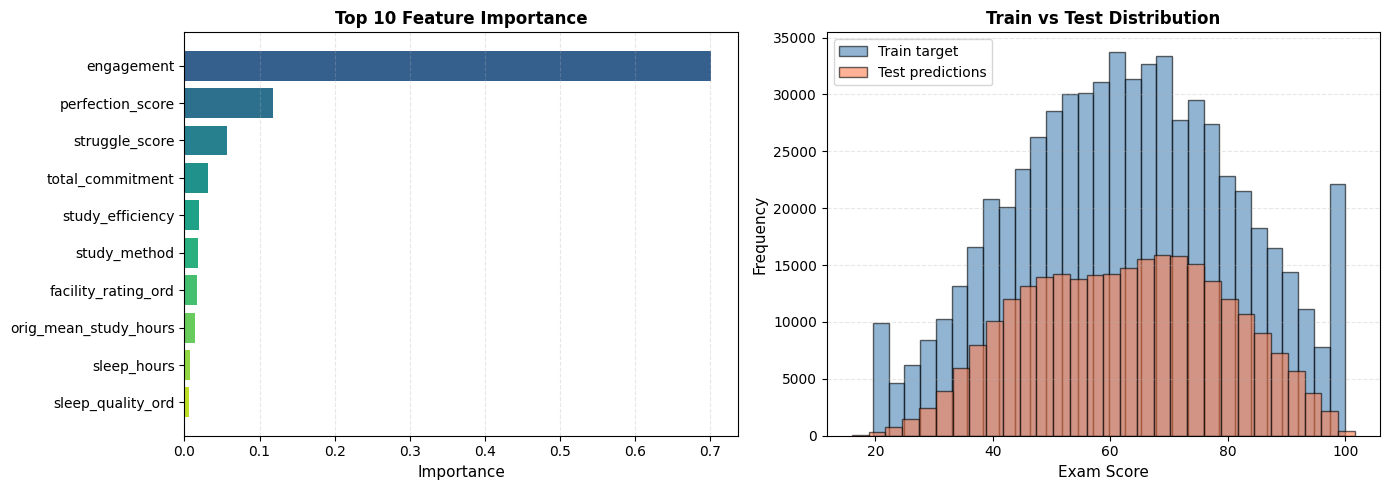

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# wykres Feature Importance
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_10)))
ax1.barh(range(len(top_10)), top_10["importance"], color=colors)
ax1.set_yticks(range(len(top_10)))
ax1.set_yticklabels(top_10["feature"])
ax1.set_xlabel('Importance', fontsize=11)
ax1.set_title('Top 10 Feature Importance', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.invert_yaxis()

# wykres Prediction Distribution
ax2 = axes[1]
ax2.hist(y, bins=30, alpha=0.6, label="Train target", color='steelblue', edgecolor='black')
ax2.hist(final_test_preds, bins=30, alpha=0.6, label="Test predictions", color='coral', edgecolor='black')
ax2.set_xlabel('Exam Score', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Train vs Test Distribution', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('model_summary.png', dpi=150, bbox_inches='tight')
plt.show()